In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
import torchvision
from glob import glob
import random
import pandas as pd
from PIL import Image
from helper_functions import walk_through_dir, plot_loss_curves, set_seeds
from helper_functions import pred_and_plot_image
from going_modular.model_builder import Net
from going_modular.data_setup import create_dataloaders
from going_modular.engine import train, test_step
from going_modular.utils import save_model


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# get data location
data_path = "./dataset/chest_xray/"
walk_through_dir(data_path)

There are 3 directories and 0 images in './dataset/chest_xray/'.
There are 2 directories and 0 images in './dataset/chest_xray/test'.
There are 0 directories and 234 images in './dataset/chest_xray/test/NORMAL'.
There are 0 directories and 390 images in './dataset/chest_xray/test/PNEUMONIA'.
There are 2 directories and 0 images in './dataset/chest_xray/train'.
There are 0 directories and 1341 images in './dataset/chest_xray/train/NORMAL'.
There are 0 directories and 3875 images in './dataset/chest_xray/train/PNEUMONIA'.
There are 2 directories and 0 images in './dataset/chest_xray/val'.
There are 0 directories and 8 images in './dataset/chest_xray/val/NORMAL'.
There are 0 directories and 8 images in './dataset/chest_xray/val/PNEUMONIA'.


Random image path: PNEUMONIA
Image class: train
Image shape (520, 880)


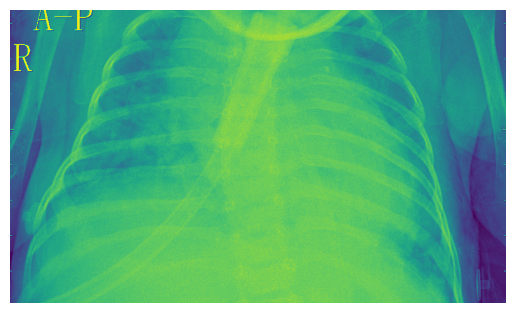

In [4]:
# get all images
image_path_list = list(glob(data_path +"*/*/*.jpeg"))

# pick a random image
random_image_path = random.choice(image_path_list)

# parent file and parent image
parent = os.path.dirname(random_image_path)

# open image 
img = Image.open(random_image_path)

# view with plt
img_plt = np.asarray(img)
plt.imshow(img_plt)
print(f"Random image path: {parent.split('/')[4]}")
print(f"Image class: {parent.split('/')[3]}")
print(f"Image shape {img_plt.shape}")
plt.axis(False);

In [5]:
# tranform 
# data_transform = transforms.Compose([
#     transforms.Resize(299),
#     transforms.CenterCrop(299),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                           [0.229, 0.224, 0.225]) ])
auto_transform = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT.transforms()
auto_transform

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [6]:
# getting train and test data loader in place
train_dir = data_path + "train/"
test_dir = data_path + "test/"
val_dir = data_path + "val/"

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir, test_dir=test_dir,
    train_transform=auto_transform, test_trainsform=auto_transform,
    train_batch_size=4, test_batch_size=1)


# alone validation data
val_data = torchvision.datasets.ImageFolder(root=val_dir, transform=auto_transform)
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=True, pin_memory=True)

print(class_names)
print(f'Number of train images: {len(train_dataloader)} for batch')
print(f'Number of test images: {len(test_dataloader)} for batch')
print(f'Number of test images: {len(val_dataloader)} for batch')

['NORMAL', 'PNEUMONIA']
Number of train images: 1304 for batch
Number of test images: 624 for batch
Number of test images: 16 for batch


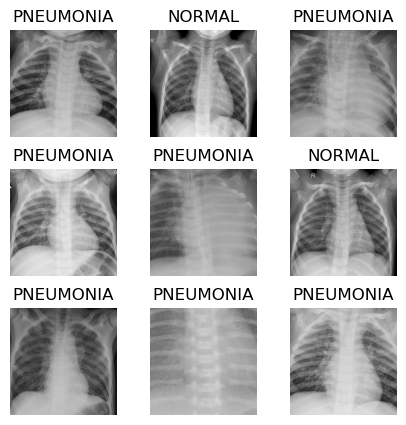

In [7]:
ncol = 3
nrow = 3
fig, axes = plt.subplots(ncol, nrow, figsize=(5,5))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrow):
    for j in range(ncol):
        inputs, classes = next(iter(train_dataloader))
        input_img = inputs[0]
        class_label = classes[0]
        inp = input_img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        axes[i, j].imshow(inp)
        axes[i, j].set_title(class_names[class_label.item()])
        axes[i, j].axis('off')

plt.show()

In [8]:
# model
model = torchvision.models.inception_v3(weights="DEFAULT").to(device)
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [9]:
summary(model=model, input_size=[1,3,256,256],  col_names=["input_size", "output_size", "num_params","mult_adds", "trainable"],
       col_width=18, row_settings=["var_names"], depth=5) 

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025831440/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type (var_name))                  Input Shape        Output Shape       Param #            Mult-Adds          Trainable
Inception3 (Inception3)                  [1, 3, 256, 256]   [1, 1000]          3,326,696          --                 True
├─BasicConv2d (Conv2d_1a_3x3)            [1, 3, 256, 256]   [1, 32, 127, 127]  --                 --                 True
│    └─Conv2d (conv)                     [1, 3, 256, 256]   [1, 32, 127, 127]  864                13,935,456         True
│    └─BatchNorm2d (bn)                  [1, 32, 127, 127]  [1, 32, 127, 127]  64                 64                 True
├─BasicConv2d (Conv2d_2a_3x3)            [1, 32, 127, 127]  [1, 32, 125, 125]  --                 --                 True
│    └─Conv2d (conv)                     [1, 32, 127, 127]  [1, 32, 125, 125]  9,216              144,000,000        True
│    └─BatchNorm2d (bn)                  [1, 32, 125, 125]  [1, 32, 125, 125]  64                 64                 True
├─BasicConv2d (Conv

In [10]:
# freeze model 
for param in model.parameters():
    param.requires_grad = False   
    
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
model.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(2048,128),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(128,6))
model.aux_logits = False

In [11]:
# loss, optimizer & # LR by a factor of 0.1 every 10 epochs
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [12]:
train(model=model, train_dataloader=train_dataloader, test_dataloader=val_dataloader,
      optimizer=optimizer, loss_fn=loss_fn, epochs=20, device=device, 
      my_scheaduler=exp_lr_scheduler)

  5%|▌         | 1/20 [01:27<27:43, 87.56s/it]

Epoch: 1 | train_loss: 0.4650 | train_acc: 0.7906 | test_loss: 0.5602 | test_acc: 0.6250


 10%|█         | 2/20 [02:51<25:40, 85.58s/it]

Epoch: 2 | train_loss: 0.3754 | train_acc: 0.8357 | test_loss: 0.6853 | test_acc: 0.5625


 15%|█▌        | 3/20 [04:15<24:01, 84.78s/it]

Epoch: 3 | train_loss: 0.3495 | train_acc: 0.8520 | test_loss: 0.6672 | test_acc: 0.5625


 20%|██        | 4/20 [05:39<22:31, 84.47s/it]

Epoch: 4 | train_loss: 0.3468 | train_acc: 0.8499 | test_loss: 0.2976 | test_acc: 1.0000


 25%|██▌       | 5/20 [07:05<21:15, 85.06s/it]

Epoch: 5 | train_loss: 0.3453 | train_acc: 0.8510 | test_loss: 0.4949 | test_acc: 0.6875


 30%|███       | 6/20 [08:37<20:23, 87.39s/it]

Epoch: 6 | train_loss: 0.3387 | train_acc: 0.8560 | test_loss: 0.4121 | test_acc: 0.6875


 35%|███▌      | 7/20 [10:07<19:05, 88.09s/it]

Epoch: 7 | train_loss: 0.3365 | train_acc: 0.8566 | test_loss: 0.3383 | test_acc: 0.7500


 40%|████      | 8/20 [11:34<17:34, 87.91s/it]

Epoch: 8 | train_loss: 0.3255 | train_acc: 0.8581 | test_loss: 0.8953 | test_acc: 0.5625


 45%|████▌     | 9/20 [13:02<16:07, 87.94s/it]

Epoch: 9 | train_loss: 0.3312 | train_acc: 0.8606 | test_loss: 0.7776 | test_acc: 0.5625


 50%|█████     | 10/20 [14:30<14:40, 88.04s/it]

Epoch: 10 | train_loss: 0.3306 | train_acc: 0.8591 | test_loss: 0.5032 | test_acc: 0.6250


 55%|█████▌    | 11/20 [15:59<13:14, 88.29s/it]

Epoch: 11 | train_loss: 0.3073 | train_acc: 0.8744 | test_loss: 0.5718 | test_acc: 0.5625


 60%|██████    | 12/20 [17:28<11:47, 88.43s/it]

Epoch: 12 | train_loss: 0.3064 | train_acc: 0.8683 | test_loss: 0.4791 | test_acc: 0.6875


 65%|██████▌   | 13/20 [18:56<10:18, 88.35s/it]

Epoch: 13 | train_loss: 0.3143 | train_acc: 0.8646 | test_loss: 0.6270 | test_acc: 0.5625


 70%|███████   | 14/20 [20:26<08:52, 88.67s/it]

Epoch: 14 | train_loss: 0.3051 | train_acc: 0.8700 | test_loss: 0.4660 | test_acc: 0.6250


 70%|███████   | 14/20 [21:45<09:19, 93.26s/it]


KeyboardInterrupt: 

In [ ]:
train_mo

In [ ]:
# epochs = 20

# for epoch in tqdm(range(epochs)):
#     print(f"Epoch: {epoch} \n-------")
#     train_step(model= model,dataloader=train_dataloader, device=device,
#                loss_fn=loss_fn, optimizer=optimizer )

#     test_step(model=model, dataloader=test_dataloader, 
#               device=device, loss_fn=loss_fn)    

In [ ]:
train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
      optimizer=optimizer, loss_fn=loss_fn, epochs=20, device=device)



1. `base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))`:
   - `Xception`: This loads the Xception model architecture, a deep convolutional neural network, which is pre-trained on the ImageNet dataset.
   - `weights='imagenet'`: Specifies that the model should be initialized with pre-trained weights from the ImageNet dataset.
   - `include_top=False`: Excludes the top (classification) layer of the model, which allows us to add our own custom classification layers.
   - `pooling='avg'`: Uses global average pooling to convert the 3D output tensor of the base model into a 1D tensor.
   - `input_shape=(256, 256, 3)`: Specifies the input shape of the images expected by the model.

2. `base_model.trainable = False`:
   - Freezes the layers in the base model, preventing them from being updated during training.

3. `model = Sequential()`: 
   - Initializes a sequential model where layers are added sequentially.

4. `model.add(base_model)`: 
   - Adds the pre-trained Xception base model to the sequential model.

5. `model.add(BatchNormalization())`: 
   - Adds a batch normalization layer to normalize the activations of the previous layer.

6. `model.add(Dropout(0.45))`: 
   - Adds a dropout layer with a dropout rate of 0.45 to prevent overfitting by randomly dropping a fraction of input units during training.

7. `model.add(Dense(220, activation='relu'))`:
   - Adds a fully connected dense layer with 220 units and ReLU activation function.

8. `model.add(Dropout(0.25))`:
   - Adds another dropout layer with a dropout rate of 0.25.

9. `model.add(Dense(60,activation='relu'))`:
   - Adds another fully connected dense layer with 60 units and ReLU activation function.

10. `model.add(Dense(1, activation='sigmoid'))`:
    - Adds the output layer with 1 unit and sigmoid activation function for binary classification.

11. `model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])`:
    - Compiles the model with the Adamax optimizer and a learning rate of 0.001, binary crossentropy loss function for binary classification, and accuracy as the evaluation metric.

12. `model.summary()`: 
    - Prints a summary of the model architecture, including the number of parameters in each layer.

In [ ]:
# Load the Xception base model without the top (classification) layer
base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))

# Freeze the layers in the base model
base_model.trainable = False

# Build Model 
model = Sequential()

# Base Model 
model.add(base_model)

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.45)) 

# Dense Layer 1
model.add(Dense(220, activation='relu'))

# Dropout Layer
model.add(Dropout(0.25)) 

# Dense Layer 2 
model.add(Dense(60,activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
import torchvision.models as models

In [ ]:
base_model = models.xception(pretrained=True)

###### **<h1 align="center"><span style="color:#6A5ACD;">Compile and Fitting</span>**

In [ ]:
#Early_Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Fitting Model
history = model.fit_generator(train_ds,
                        epochs= 20,
                        validation_data = validation_ds,
                        callbacks = early_stopping)

###### **<h1 align="center"><span style="color:#6A5ACD;">Val Loss and Accuracy</span>**

In [ ]:
# Evaluate the model on the validation dataset
validation_loss, validation_accuracy = model.evaluate(validation_ds)

# Print the validation loss and accuracy
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

In [ ]:
# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Set the background style
plt.style.use('seaborn-darkgrid')

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

# <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:#6A5ACD;">Model Predictions</p>

In [ ]:
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/'
print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

# Define a function to plot images with their true and predicted labels
def plot_images_with_predictions(model, dataset, class_labels, num_images=40, num_images_per_row=5):
    # Generate predictions for a set number of images
    predictions = model.predict(dataset)
    
    # Shuffle the dataset
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))
    
    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(dataset_shuffled.take(num_images)):
        # Convert tensor to NumPy array
        images = images.numpy()
        
        # Iterate over each image in the batch
        for j in range(len(images)):
            if i * num_images_per_row + j < num_images:  # Check if the total number of images exceeds the desired count
                predicted_class = class_labels[np.argmax(predictions[i * num_images_per_row + j])]
                true_class = class_labels[np.argmax(labels[j])]
                
                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, i * num_images_per_row + j + 1)
                plt.imshow(images[j].astype("uint8"))  
                plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions on random 20 images from the testing dataset
print('Testing Images:')
plot_images_with_predictions(model, test_ds, class_labels, num_images=20)

In [ ]:
# Path to the directory containing the images
directory_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/'

# Select N image files from the directory
image_files = os.listdir(directory_path)[:5]

# Create a figure and axes for subplots
fig, axs = plt.subplots(1, len(image_files), figsize=(15, 5))

# Load and preprocess each image, make predictions, and display them using a loop
for i, image_file in enumerate(image_files):
    img_path = os.path.join(directory_path, image_file)
    # Load the image using OpenCV
    img = cv2.imread(img_path)
    # Resize the image to (256, 256)
    img = cv2.resize(img, (256, 256)) 

    # Normalize pixel values
    img_array = img.astype(np.float32) / 255.0  

    # Expand the dimensions to match the input shape expected by the model
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model.predict(img_array)
    actual_prediction = (predictions > 0.5).astype(int)

    # Display the image with predicted label
    # Convert BGR to RGB for displaying with matplotlib
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
    axs[i].axis('off')
    if actual_prediction[0][0] == 0:
        predicted_label = 'Normal'
    else:
        predicted_label = 'PNEUMONIA'
    axs[i].set_title(f'Predicted: {predicted_label}')

# Adjust layout
plt.tight_layout()
plt.show()